In [1]:
import os
os.chdir('../')

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *

Loading imports


In [3]:
torch.cuda.set_device(3)

## Load Model

In [4]:
import geffnet
m = geffnet.efficientnet_b0(pretrained=True, drop_rate=0.25, drop_connect_rate=0.2)

In [5]:
m.classifier = nn.Linear(m.classifier.in_features, 6)

In [6]:
# m = xresnet18(c_out=6) # 2:50 per epoch

In [7]:
name = 'baseline_efficientnet'

In [8]:
dbch = get_data(512, 128, splits=Meta.splits_stg1)
learn = get_learner(dbch, m)

In [9]:
learn.model

GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishJit()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishJit()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishJit()
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity

## Training

In [10]:
# learn.lr_find()

In [11]:
do_fit(learn, 12, 4e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.106148,0.118767,0.964203,0.921510,11:07
1,0.108650,0.129843,0.961296,0.915921,11:14
2,0.105181,0.124454,0.963337,0.926272,11:13
3,0.102496,0.141524,0.958735,0.906130,11:11
4,0.097350,0.131841,0.963422,0.922643,11:12
5,0.096679,0.115356,0.965529,0.928703,11:16
6,0.092116,0.105254,0.969966,0.936992,11:17
7,0.088397,0.094133,0.971400,0.941282,11:18
8,0.082801,0.090660,0.973387,0.946018,11:14
9,0.077937,0.086982,0.973966,0.947928,11:10


In [12]:
learn.dls = get_data(256, 256, splits=Meta.splits_stg1)
learn.load(f'runs/{name}-1')

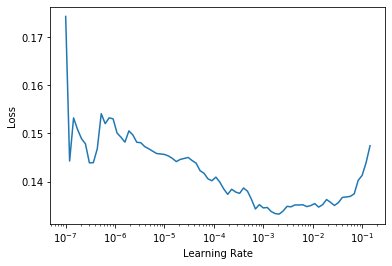

In [13]:
learn.lr_find()

In [14]:
do_fit(learn, 12, 4e-3)
learn.save(f'runs/{name}-2')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.080668,0.085098,0.974200,0.948475,30:13
1,0.074296,0.081134,0.974947,0.950805,30:07
2,0.075266,0.089526,0.972871,0.945267,30:06
3,0.072199,0.082292,0.974861,0.950971,30:10
4,0.069627,0.085243,0.974802,0.949647,29:58
5,0.070858,0.083138,0.975483,0.951875,29:36
6,0.069187,0.080335,0.975710,0.951391,29:37
7,0.063798,0.080090,0.975710,0.951887,29:32
8,0.060465,0.080299,0.976389,0.952957,29:33
9,0.057275,0.079650,0.976355,0.953619,29:31


In [10]:
learn.load(f'runs/{name}-2')
learn.dls = get_data(128, 384, splits=Meta.splits_stg1, img_dir=path_jpg)
do_fit(learn, 4, 2e-4)
learn.save(f'runs/{name}-3')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.060322,0.077982,0.976728,0.954714,1:11:11
1,0.059029,0.076913,0.976994,0.955249,1:11:16
2,0.055977,0.077632,0.977155,0.955529,1:11:15
3,0.053745,0.078960,0.977208,0.955707,1:11:23


## Submission

In [10]:
learn.load(f'runs/{name}-3')
sub_fn = f'subm/{name}'

In [11]:
learn.dls = get_test_data(Meta.df_tst, bs=256, sz=384)

In [12]:
ob = learn.dls.one_batch()

In [13]:
preds,targs = learn.get_preds()

In [14]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [15]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:03<00:00, 7.58MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [16]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14329418,
 'totalBytes': 27277209,
 'date': '2020-01-30T04:25:33.967Z',
 'description': 'baseline_efficientnet',
 'errorDescription': None,
 'fileName': 'baseline_efficientnet.csv',
 'publicScore': '1.42046',
 'privateScore': '0.06229',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14329418/14329418.raw'}